# Model 4: Stacked LSTM
    - 2 LSTM layers

In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


## Preprocess data

In [2]:
#Imports 
from __future__ import print_function

import numpy as np
import os
import shutil
import fnmatch

from collections import OrderedDict
from nltk import word_tokenize

data_path='/home/ubuntu/data/training/keras/aclImdb/'



# Generator of list of files in a folder and subfolders
def gen_find(filepath,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepath):
            yield os.path.join(path,name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

def tokenize(sentences):
    print( 'Tokenizing...',)
    tokens = []
    for sentence in sentences:
        tokens += [word_tokenize(sentence.decode('utf-8'))]
    print('Done!')
    return tokens

def build_dict(sentences):
    print( 'Building dictionary..',)
    wordcount = dict()
    for ss in sentences:
        for w in ss:
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1

    counts = wordcount.values()
    keys = wordcount.keys()
    sorted_idx = np.argsort(counts)[::-1]

    worddict = dict()
    for idx, ss in enumerate(sorted_idx):
        worddict[keys[ss]] = idx+2  # leave 0 and 1 (UNK)
    print( np.sum(counts), ' total words ', len(keys), ' unique words')
    return worddict, wordcount

def generate_sequence(sentences, dictionary):
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]
    return seqs

#Data extraction

#Extract training sentences
sentences_trn_pos = tokenize(read_sentences(data_path+'train/pos/'))
sentences_trn_neg = tokenize(read_sentences(data_path+'train/neg/'))
sentences_trn = sentences_trn_pos + sentences_trn_neg

#Build train dictionary
worddict, wordcount = build_dict(sentences_trn)

#Generate train data
train_x_pos = generate_sequence(sentences_trn_pos, worddict)
train_x_neg = generate_sequence(sentences_trn_neg, worddict)
X_train_full = train_x_pos + train_x_neg
y_train_full = [1] * len(train_x_pos) + [0] * len(train_x_neg)


#Read test sentences and generate target y
sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

test_x_pos = generate_sequence(tokenize(sentences_tst_pos), worddict)
test_x_neg = generate_sequence(tokenize(sentences_tst_neg), worddict)
X_test_full = test_x_pos + test_x_neg
y_test_full = [1] * len(test_x_pos) + [0] * len(test_x_neg)


print('Preprocess done!')

Tokenizing...
Done!
Tokenizing...
Done!
Building dictionary..
7056193  total words  135098  unique words
Tokenizing...
Done!
Tokenizing...
Done!
Preprocess done!


## Prepare sequences to model


In [3]:
max_features = 20000 # Number of most frequent words selected. the less frequent recode to 0
max_len = 100  # cut texts after this number of words (among top max_features most common words)


#Select the most frequent max_features, recode others using 0
def remove_features(x):
    return [[0 if w >= max_features else w for w in sen] for sen in x]

X_train = remove_features(X_train_full)
X_test  = remove_features(X_test_full)
y_train = y_train_full
y_test = y_test_full


# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)


# Cut or complete the sentences to length = maxlen
from keras.preprocessing import sequence

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


Pad sequences (samples x time)
X_train shape: (25000, 100)
X_test shape: (25000, 100)


## Build model

In [4]:
# Model
dim_embedings = 128 #Dimension of the embedings vector
num_hidden_rnn = 128 #Num of neurons in the Recurent network 


from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Dropout, Dense, merge
from keras.optimizers import RMSprop

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = Input(shape=(max_len, ), dtype='int32') 

# LAYER 2: Create embedings
embeds = Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
droput_percent = 0.3
forwards1 = LSTM(num_hidden_rnn, return_sequences=True,
                 dropout_W=droput_percent, dropout_U=droput_percent, name='Forward_1')(embeds)
rnn_out = LSTM(num_hidden_rnn, return_sequences=False,
                 dropout_W=droput_percent, dropout_U=droput_percent, name='Forward_2')(forwards1)


# LAYER 4: Dense layer to outputs - softmax activation
output = Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = Model(input=seq_prev_input, output=output)
model_1.summary()

# Compile model and select optimizer
rms_optimizer = RMSprop(lr=0.001)
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=rms_optimizer, metrics=['accuracy'])



Build model 1 - Basic model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 128)      2560000     input_1[0][0]                    
____________________________________________________________________________________________________
Forward_1 (LSTM)                 (None, 100, 128)      131584      embedding_1[0][0]                
____________________________________________________________________________________________________
Forward_2 (LSTM)                 (None, 128)           131584      Forward_1[0][0]                  
____________________________________________________________

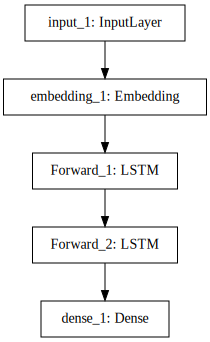

In [5]:
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model_1).create(prog='dot', format='svg'))

In [6]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 97s - loss: 0.5873 - acc: 0.6713 - val_loss: 0.4211 - val_acc: 0.8130
Epoch 2/10
25000/25000 [==============================] - 95s - loss: 0.3988 - acc: 0.8267 - val_loss: 0.3908 - val_acc: 0.8342
Epoch 3/10
25000/25000 [==============================] - 75s - loss: 0.3238 - acc: 0.8674 - val_loss: 0.4068 - val_acc: 0.8221
Epoch 4/10
25000/25000 [==============================] - 76s - loss: 0.2793 - acc: 0.8901 - val_loss: 0.3765 - val_acc: 0.8418
Epoch 5/10
25000/25000 [==============================] - 120s - loss: 0.2477 - acc: 0.9051 - val_loss: 0.4217 - val_acc: 0.8329
Epoch 6/10
25000/25000 [==============================] - 121s - loss: 0.2185 - acc: 0.9170 - val_loss: 0.3817 - val_acc: 0.8429
Epoch 7/10
25000/25000 [==============================] - 119s - loss: 0.1956 - acc: 0.9273 - val_loss: 0.5512 - val_acc: 0.8056
Epoch 8/10
25000/25000 [==================

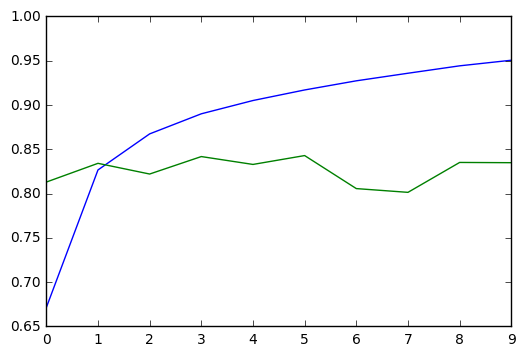

In [7]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [8]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


Accuracy:  0.83488
AUC:  0.911224864


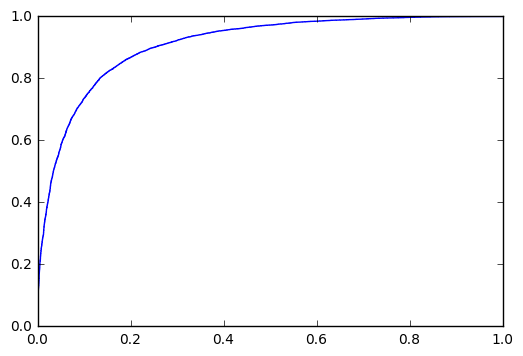

In [9]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Calculate accuracy with sklearn
print('Accuracy: ',accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print( 'AUC: ', auc(fpr, tpr))  

#Plot ROC curve
plt.plot(fpr, tpr)

In [10]:
#Evaluate one positive record
i = 1 # 1, 2, ... , 25000
print('Sentence: ',sentences_tst_pos[i])
print('target: ',y_test_full[i])
print('Prediction [neg, pos]: ', pred_test[i])

Sentence:  Inglorious Basterds makes no apologies, asks for no forgiveness, it's a no holds barred assault on the senses. Tarantino doesn't care if he offends, if he steps all over stereotypes and clichés, this is film making at it purest. It's great to see a film maker whose work clearly isn't interfeared with by the powers that be. Tarantino is a master of effortlessly cranking up immense tension and suddenly mixing it with laugh out loud moments; you're not sure if you should be looking away in disgust or rolling around laughing, either way it's a roller coaster and one not to be missed! It's not for everyone and I'm unsure how Germans will take the film, certainly if you're not a fan of Tarantino's style, this may be a little hard to swallow, but never-the-less, it is a film which simply has to be seen. No self respecting film fan should miss this. And the performance of Christoph Waltz... Oscar don't you dare ignore him!!
target:  1
Prediction [neg, pos]:  [ 0.59985101  0.40014905

In [11]:
#Evaluate one negative record
i = -2 # -2, -3, ... -25000
print('Sentence: ',sentences_tst_neg[i])
print('target: ',y_test[i])
print('Prediction [neg, pos]: ', pred_test[i])

Sentence:  The distribution was good, the subject could have been interessant and comic. whereas, he described the wandering of an old non credible communist looking for loving sensations. Instead of this, the atmosphere is nor lively nor heavy.
target:  0
Prediction [neg, pos]:  [ 0.01090779  0.98909223]


In [12]:
# Score new text
def score_new_text(text):
    seq = generate_sequence(tokenize([text]), worddict)
    seq = remove_features(seq)
    seq = sequence.pad_sequences(seq, maxlen=max_len)
    pred_test = model_1.predict(seq, batch_size=1)
    return float(pred_test[:,1])


text = "You have to start worrying when you see that Michael Madsen is leading the Cast of any movie. I wont go through the list of shame that is his movie career.<br /><br />I watched 45 minutes and still was not sure what really was going on. The movie consisted of a love hate relationship between Madsen and Argento, Which basically was Madsen insulting her, threatening violence and generally treating her like dirt. She on the other hand loves him, then shes doesn't, then she does, the she desires him, then she loves him again......whats wrong with you woman !!!! <br /><br />The Script is awful, lousy soundtrack and pointless aggressive and crude sexuality which i believe was added to entice some viewers as the movie has little else to offer. I would have given the movie a 1 but it just about managed a 2 with a little excitement in the last 20 minutes. It did actually answer one question in the final few minutes but i am not going to share that, i will make you suffer for the full movie like i did."
print('Positive score:', score_new_text(text))

Tokenizing...
Done!
Positive score: 0.0651876404881
